In [1]:
%matplotlib inline
import os
import cv2
import ants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp, seaborn
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
from scipy import signal
from scipy.signal import find_peaks, peak_prominences
from scipy.fft import fft, fftfreq, fftshift
from tqdm import tqdm
import time

In [2]:
#find fly frames
def Fly_frame(judge):
    q3, q1 = np.percentile(judge, [80, 20], axis=0)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    #fence_high = q3+1.5*iqr
    return np.where(judge<fence_low)

In [3]:
def Dead_fish(time_range):
    if sum(i>1000 for i in time_range) > 10000:
        return True

In [4]:
class BaselineRemoval():
    '''input_array: A pandas dataframe column provided in input as dataframe['input_df_column']. It can also be a Python list object
    degree: Polynomial degree
    '''     
    def __init__(self,input_array):
        self.input_array=input_array
        self.lin=LinearRegression()

    def poly(self,input_array_for_poly,degree_for_poly):
        '''qr factorization of a matrix. q` is orthonormal and `r` is upper-triangular.
        - QR decomposition is equivalent to Gram Schmidt orthogonalization, which builds a sequence of orthogonal polynomials that approximate your function with minimal least-squares error
        - in the next step, discard the first column from above matrix.
        - for each value in the range of polynomial, starting from index 0 of pollynomial range, (for k in range(p+1))
            create an array in such a way that elements of array are (original_individual_value)^polynomial_index (x**k)
        - concatenate all of these arrays created through loop, as a master array. This is done through (np.vstack)
        - transpose the master array, so that its more like a tabular form(np.transpose)'''
        input_array_for_poly = np.array(input_array_for_poly)
        X = np.transpose(np.vstack((input_array_for_poly**k for k in range(degree_for_poly+1))))
        return np.linalg.qr(X)[0][:,1:]
    
    def IModPoly(self,degree=2,repitition=100,gradient=0.001):
        '''IModPoly from paper: Automated Autofluorescence Background Subtraction Algorithm for Biomedical Raman Spectroscopy, by Zhao, Jianhua, Lui, Harvey, McLean, David I., Zeng, Haishan (2007)
        degree: Polynomial degree, default is 2        
        repitition: How many iterations to run. Default is 100
        gradient: Gradient for polynomial loss, default is 0.001. It measures incremental gain over each iteration. If gain in any iteration is less than this, further improvement will stop
        '''

        yold=np.array(self.input_array)
        yorig=np.array(self.input_array)
#         corrected=[]

        nrep=1
        ngradient=1

        polx=self.poly(list(range(1,len(yorig)+1)),degree)
        ypred=self.lin.fit(polx,yold).predict(polx)
        Previous_Dev=np.std(yorig-ypred)

        #iteration1
        yold=yold[yorig<=(ypred+Previous_Dev)]
        polx_updated=polx[yorig<=(ypred+Previous_Dev)]
        ypred=ypred[yorig<=(ypred+Previous_Dev)]

        for i in range(2,repitition+1):
            if i>2:
                Previous_Dev=DEV
            ypred=self.lin.fit(polx_updated,yold).predict(polx_updated)
            DEV=np.std(yold-ypred)

            if np.abs((DEV-Previous_Dev)/DEV) < gradient:
                break
            else:
                for i in range(len(yold)):
                    if yold[i]>=ypred[i]+DEV:
                        yold[i]=ypred[i]+DEV
        baseline=self.lin.predict(polx)
#         corrected=yorig-baseline
        return baseline

In [5]:
def Peak(judge):
    q3, q1 = np.percentile(judge, [75, 25], axis=0)
    iqr = q3-q1
#     fence_low  = q1-1.5*iqr
    fence_high = q3+2*iqr
#     return np.where(judge>fence_high)
    return fence_high

In [6]:
def find_turning_points(s):
    whole_left = []
    whole_right = []
    whole_peaks = []
    value_left = []
    value_right = []
    value_peaks = []
    for i in range(len(s)):
        x = s[i]*10
        h = Peak(x)
        peaks, _ = signal.find_peaks(x, height=h, width=5)
        valley = (np.diff(np.sign(np.diff(s[i]))) > 0).nonzero()[0] + 1
        dist = valley.reshape(-1,1).repeat([len(peaks)],axis=1) - peaks
        dist = dist.T
        left = []
        right = []
        if len(peaks) != 0:
            for j in range(len(peaks)):
                try:
                    left.append(np.where(dist[j]<0)[0][-1])
                except:
                    peaks = peaks[:-1]
                    continue
                try:
                    right.append(np.where(dist[j]>0)[0][0])
                except:
                    left = left[:-1]
                    peaks = peaks[:-1]
        else:
            left.append(np.array(0))
            right.append(np.array(0))

        whole_left.append(valley[left])
        whole_right.append(valley[right])
        whole_peaks.append(list(peaks))
        value_left.append(x[valley[left]])
        value_right.append(x[valley[right]])
        value_peaks.append(x[peaks])
    return whole_left, whole_right, whole_peaks, value_left, value_right, value_peaks

In [7]:
def neural_connection(s):
    where_peaks = []
    for i in range(len(s)):
        x = s[i]*10
        h = Peak(x)
        peaks, _ = signal.find_peaks(x, height=h, width=5)
        where_peaks.extend(peaks)
    return where_peaks

In [8]:
arr_tp = cv2.imread('/home/mytu/zebrafish/Heatmap/tp3_100.png', 0)
tp= ants.from_numpy(arr_tp, has_components=False)
arr_fi = cv2.imread('/home/mytu/zebrafish/Heatmap/template3.tif', 2)
fi = ants.from_numpy(arr_fi.astype(np.uint32), has_components=False)

In [110]:
mat_path = '/home/zhshen/data/zebra_fish/DATA_TEMP/mytu/ANTs/aligned12/1182/fish12/test12/_1/Pos0/l.npy'
fish_mat = np.load(mat_path)

In [111]:
tp_path = '/home/zhshen/data/zebra_fish/DATA_TEMP/mytu/ANTs/tp/1182/fish12/test12/_1/Pos0/lInverseComposite.h5'

In [133]:
mi= ants.from_numpy(np.array(fish_mat[500].reshape(-1, 300), dtype = np.uint32), has_components=False)
transformed = ants.apply_transforms(fixed=mi, moving=tp, transformlist=tp_path, interpolator='nearestNeighbor')

(-0.5, 299.5, 499.5, -0.5)

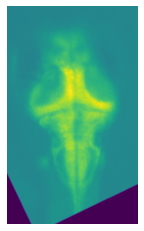

In [132]:
# plt.imshow(fish_mat[500].reshape(-1,250), vmin=800, vmax=1500)
plt.imshow(fish_mat[500].reshape(-1,300))
plt.axis('off')

In [134]:
fish_value = transformed.numpy()

In [135]:
#fish template
f_value = fish_value.copy()
f_value[f_value>0] = 1
fish = fish_mat * f_value.flatten()
fish_index = np.where(fish[0]==0)
fish_only = np.delete(fish, fish_index, axis=1)
fly = Fly_frame(fish_only)
result = Counter(fly[0])
need_move = [k for k, v in result.items() if v > 1000]

In [136]:
fish_mat_preped = np.delete(fish_mat, need_move, axis=0)

In [137]:
a = np.expand_dims(transformed.numpy().flatten(), 0)
b = a.repeat([100], axis=0)
c = np.zeros_like(b)
for i in range(1, b.shape[0]+1):
    c[i-1] = np.where(b[i-1] == i, 1, 0)

In [138]:
time_max = np.max(fish_mat_preped, axis=0)
time_min = np.min(fish_mat_preped, axis=0)
time_range = time_max - time_min

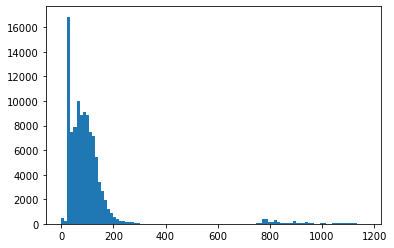

In [82]:
plt.hist(time_range, bins=100)
plt.show()

In [139]:
if Dead_fish(time_range):
    print(True)
else:
    outliers = np.where(time_range>500)
    fish_mat_preped.T[outliers] = 0
    time = np.dot(c, fish_mat_preped.T)
    time = time.T / np.sum(c, axis=1)
    time = time.T

In [140]:
b, a = signal.butter(30, 0.3, 'lowpass') 
filtedData1 = signal.filtfilt(b, a, time)

In [141]:
if len(need_move) > 1:
    vary = np.arange(0, len(need_move))
    need_interp = need_move - vary
    interp = np.insert(filtedData1, need_interp, np.nan, axis=1)
else:
    interp = np.insert(filtedData1, need_move, np.nan, axis=1)

In [142]:
df = pd.DataFrame(interp)
df.interpolate(method='linear', axis=1, inplace=True)
filtedData1 = np.array(df)

In [143]:
filtedData1 = filtedData1.T[10:-10].T

In [144]:
baseline = np.zeros([filtedData1.shape[0], filtedData1.shape[1]])
polynomial_degree=6
for i in range(len(filtedData1)):
    baseObj = BaselineRemoval(filtedData1[i])
    baseline[i] = baseObj.IModPoly(polynomial_degree)

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

arrays to stack must

In [145]:
s = (filtedData1.T[10:-10].T - baseline.T[10:-10].T) / baseline.T[10:-10].T

In [146]:
whole_left, whole_right, whole_peaks, value_left, value_right, value_peaks = np.asarray(find_turning_points(s))

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, wh

In [44]:
for index, height in enumerate(value_peaks):
    print(np.max(height))

0.7443278103928903
0.7491789630402736
0.8735628873762523
0.5359285725802061
0.5690087484860934
0.8405830052842453
0.7749916033552733
0.6592161460720372
0.8337175520816316
0.6730620432846389
0.9347426293332946
1.1353351137717198
0.8921279400486731
0.6785266597516852
0.9203443301455292
0.9331122939262739
0.9589796326129836
0.5186829557340166
0.5564571970784
0.9169886981962889
0.7346120833785987
0.8890109828368866
0.4266254600503377
1.166007501402833
0.6892154237296372
0.9297665280320678
0.8342187317200307
0.8032471600169275
0.5557015737306986
0.754381715138523
0.9122307427664865
0.7035538248384763
0.6306992625858678
0.8933694557460299
1.138408209422104
0.385336239513718
0.7686989739668844
0.4975757350421888
0.6574170900093855
0.7123272608057231
0.8386482018232079
0.6028266284439336
0.6244721645699987
0.7567695814653991
0.658417703795984
0.9672615195896606
0.7415212578508539
0.819770879237756
0.9279127566248708
0.672511193671594
0.6045398396862118
0.7937222853971477
0.7528955273305421
0.7

In [147]:
where_peaks = neural_connection(s)

In [148]:
peak_indexs = sorted(np.array(list(set(where_peaks))))

In [149]:
connection_mat = np.zeros([100, len(peak_indexs)])
value_mat = np.zeros([100, len(peak_indexs)])
for index, whole_peak in enumerate(whole_peaks):
    for j, peak in enumerate(peak_indexs):
        if peak in whole_peak:
            connection_mat[index][j] = 1
            value_mat[index][j] = s[index][peak]

<Figure size 1440x3600 with 0 Axes>

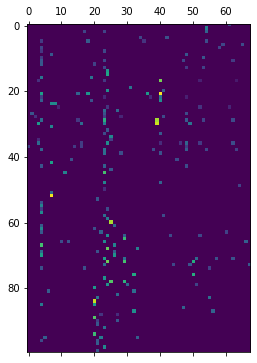

In [150]:
plt.figure(figsize=(20,50))
plt.matshow(value_mat)
plt.show()

In [151]:
corr = np.corrcoef(connection_mat)
corr[np.isnan(corr)] = 0
corr_value = np.corrcoef(value_mat)
corr_value[np.isnan(corr_value)] = 0

/home/software/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning:

invalid value encountered in true_divide

/home/software/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning:

invalid value encountered in true_divide



<AxesSubplot:>

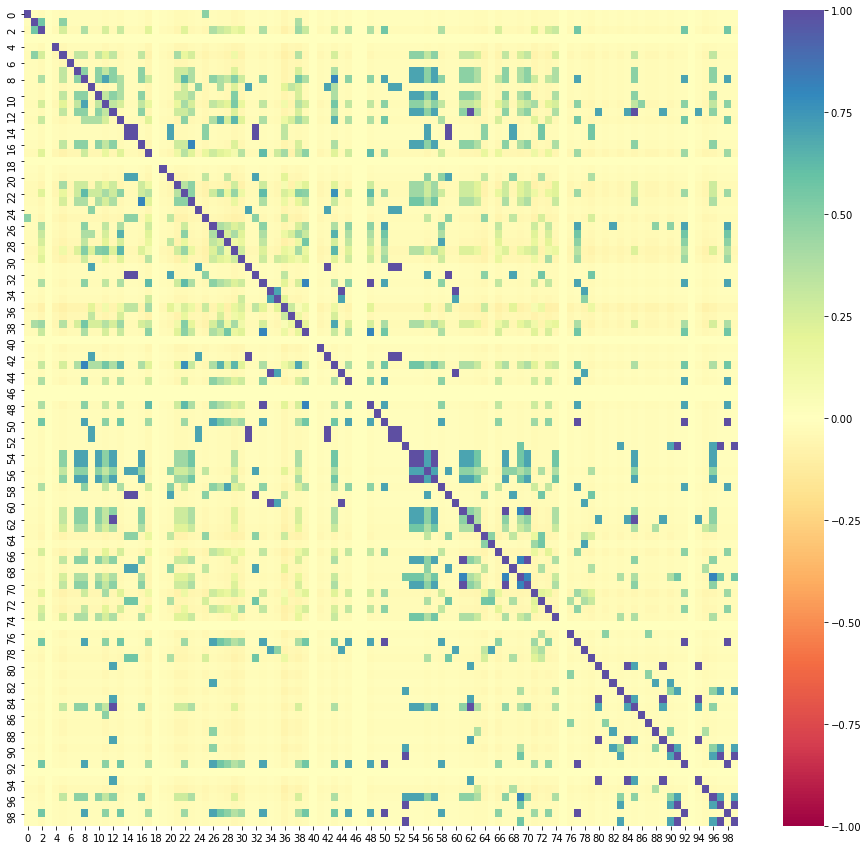

In [152]:
plt.figure(figsize = (16,15))
seaborn.heatmap(corr, center=0, cmap="Spectral", annot=False, vmin=-1, vmax=1)

<AxesSubplot:>

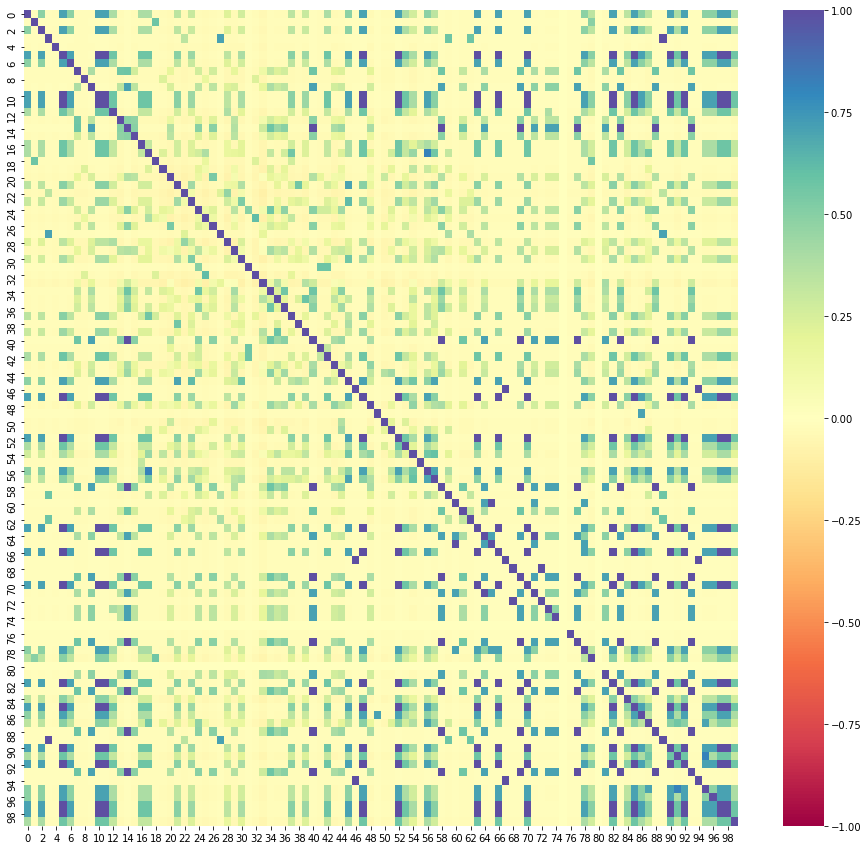

In [160]:
plt.figure(figsize = (16,15))
seaborn.heatmap(demo, center=0, cmap="Spectral", annot=False, vmin=-1, vmax=1)

<AxesSubplot:>

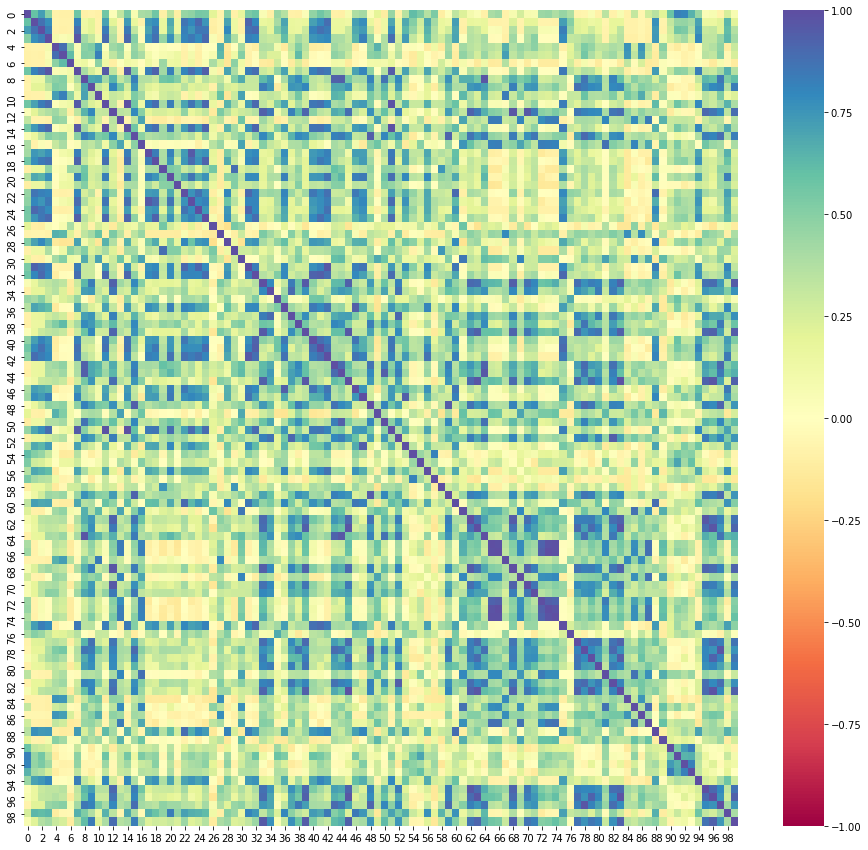

In [39]:
plt.figure(figsize = (16,15))
seaborn.heatmap(corr_value, center=0, cmap="Spectral", annot=False, vmin=-1, vmax=1)

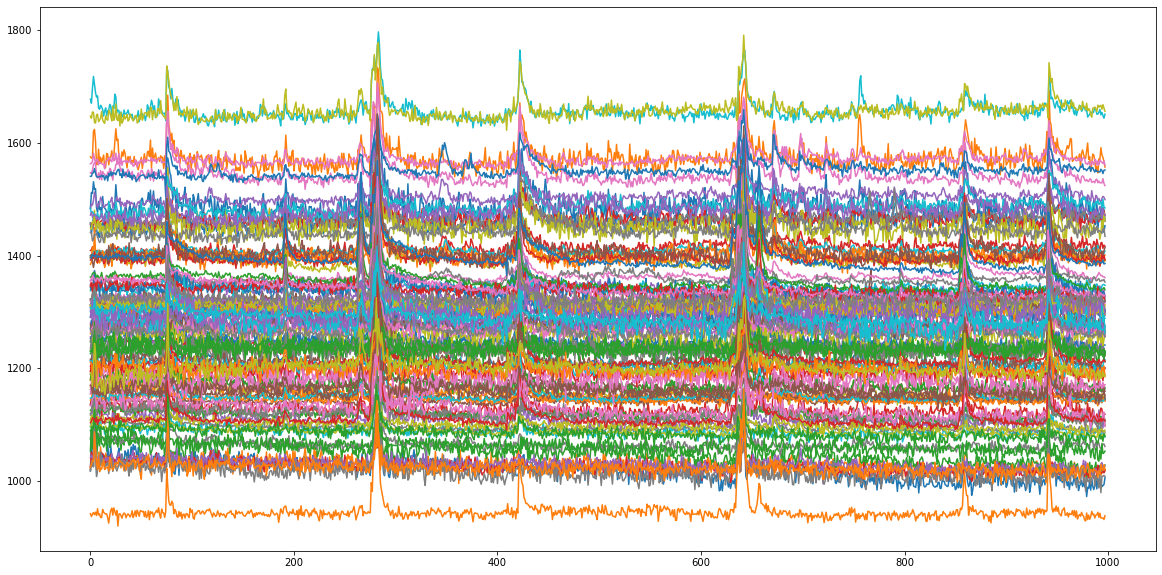

In [32]:
plt.figure(figsize=(20,10))
for i in range(100):
    plt.plot(time[i])

In [41]:
# create a binary pickle file 
# f = open("file.pkl","wb")

In [58]:
import pickle

In [158]:
df=open('/home/zhshen/data/zebra_fish/DATA_TEMP/mytu/ANTs/aligned12_raw/feature_extraction/features/drugs/HL-99/fish34/test34/_1/Pos0/3.pkl','rb')
data3=pickle.load(df)
df.close()

In [159]:
demo = data3['connection_corr']